In [1012]:
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
from matplotlib import pyplot as plt

# Import dataset and some examples

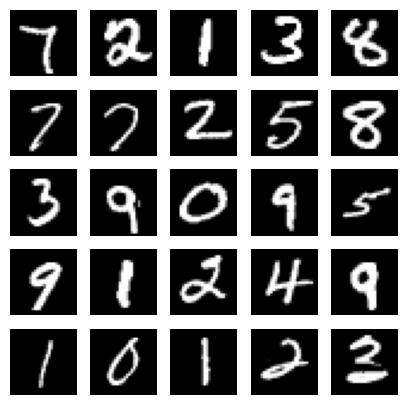

In [1013]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
# sample 25 mnist digits from train dataset
indexes = np.random.randint(0, X_train.shape[0], size=25)
images = X_train[indexes]
labels = X_train[indexes]


# plot the 25 mnist digits
plt.figure(figsize=(5,5))
for i in range(len(indexes)):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
plt.show()
plt.savefig("mnist-samples.png")
plt.close('all')

# Flatten the data for train and applying one hot encode , standaization

In [1014]:
X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape( X_test.shape[0],-1)

NUM_CLASSES = 10

Y_train = Y_train.reshape(Y_train.shape[0], -1)
Y_test = Y_test.reshape(Y_test.shape[0], -1)
Y_train = to_categorical(Y_train, NUM_CLASSES)
Y_test = to_categorical(Y_test, NUM_CLASSES)

X_train = (X_train - np.mean(X_train)) / np.std(X_train)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


In [1015]:
print(X_train.min(), X_train.max())

-0.424073894391566 2.821543345689335


# Activation Functions

In [1016]:
def sigmoid(Z):
    Z = np.clip(Z, -500, 500)  # Limit the range of Z to avoid overflow/underflow
    A = 1. / (1. + np.exp(-Z))
    return A

def derivative_sigmoid(Z):
    A = sigmoid(Z)
    return A * (1 - A)


def softmax(z):
    expZ = np.exp(z)
    return expZ / (np.sum(expZ, 0))

# Initialize Parameters

In [1017]:
def initialize_parameters(layers_size):
  parameters={}
  for l in range(1,len(layers_size)):
    #we divide here bc we should avoid Vanishing gradient problem
    parameters["W"+str(l)]= np.random.randn(layers_size[l],layers_size[l-1])/np.sqrt(layers_size[l-1])
    parameters["b"+str(l)]=np.random.randn(layers_size[l],1)/np.sqrt(layers_size[l-1])
  return parameters
layer_dims=[X_train.shape[1],20,10,Y_train.shape[1]]
p=initialize_parameters(layer_dims)
for l in range(1,len(layer_dims)):
  print("shape of w"+str(l)+":",p["W"+str(l)].shape)
  print("shape of b"+str(l)+":",p['b'+str(l)].shape)

shape of w1: (20, 784)
shape of b1: (20, 1)
shape of w2: (10, 20)
shape of b2: (10, 1)
shape of w3: (10, 10)
shape of b3: (10, 1)


# Forward Propagation

In [1018]:
def forward_propagation(X,Parameters):
  forward_cahce={}
  L=len(Parameters)//2
  forward_cahce["A"+str(0)]=X #first layer will be the x
  for l in range (1,L+1):
    forward_cahce["Z"+str(l)]=forward_cahce["A"+str(l-1)].dot(Parameters["W"+str(l)].T)+Parameters["b"+str(l)].T
    forward_cahce["A"+str(l)]=sigmoid(forward_cahce["Z"+str(l)])
  return forward_cahce,forward_cahce["A"+str(L)]
 
fcahce,A=forward_propagation(X_train,p)
for l in range(len(p)//2+1):
  print(fcahce['A'+str(l)].shape)

(60000, 784)
(60000, 20)
(60000, 10)
(60000, 10)


In [1019]:
forw_cache,aL = forward_propagation(X_train, p)

for l in range(len(p) // 2 + 1):
    print("Shape of A" + str(l) + " :", forw_cache['A' + str(l)].shape)

Shape of A0 : (60000, 784)
Shape of A1 : (60000, 20)
Shape of A2 : (60000, 10)
Shape of A3 : (60000, 10)


# Cost Function


In [1020]:
def compute_cost(AL, Y):
    mse = np.mean(((AL - Y) ** 2)) / 2
    # m = Y.shape[1]
    # cost = -(1. / m) * np.sum(Y * np.log(AL))
    # cost = np.squeeze(cost)
    return mse

# Backward Propagation


In [1021]:
def backward_propagation(AL, Y, parameters, forward_cache):
    deltas = {}
    L = len(parameters) // 2
    m = AL.shape[0]

    deltas["dZ" + str(L)] = AL - Y
    deltas["dW" + str(L)] = 1. / m * np.dot(deltas["dZ" + str(L)].T, forward_cache['A' + str(L - 1)])
    deltas["db" + str(L)] = 1. / m * np.sum(deltas["dZ" + str(L)], axis=0, keepdims=True)
    for l in reversed(range(1, L)):
        deltas["dZ" + str(l)] = (np.dot(parameters['W' + str(l + 1)].T, deltas["dZ" + str(l + 1)].T)).T * derivative_sigmoid(
            forward_cache['Z' + str(l)])
        deltas["dW" + str(l)] = 1. / m * np.dot(deltas["dZ" + str(l)].T, forward_cache['A' + str(l - 1)])
        deltas["db" + str(l)] = 1. / m * np.sum(deltas["dZ" + str(l)], axis=0, keepdims=True)

    return deltas

# Update Parameters

In [1022]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2

    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)].T

    return parameters

# Predictions

In [1023]:
def predict(X, y, parameters):
    m = y.shape[0]
    _,y_pred = forward_propagation(X, parameters)

    # print(y_pred.shape)
    y = np.argmax(y, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    # print('\n', y_pred)
    # print('\n', y)
    return np.round((np.sum(y_pred == y) / m),2)

# Complete Model

In [1024]:
def NN(X, Y, num_of_layers, layer_dims):
    # np.random.seed(95)
    lr = 0.1
    iters = 101
    tot_layers = [784]
    for i in layer_dims:
      tot_layers.append(i)
    parameters = initialize_parameters(tot_layers)
    # deltas = {}
    for i in range(0, iters):

        forward_cache,AL = forward_propagation(X, parameters)

        cost = compute_cost(AL, Y)

        deltas = backward_propagation(AL, Y, parameters, forward_cache)

        parameters = update_parameters(parameters, deltas, lr)
        if i %10 == 0:
            print("\niter:{} \t cost: {} \t train_acc:{} \t test_acc:{}"
                  .format(i, np.round(cost, 2),
                          predict(X_train, Y_train, parameters)*100,
                          predict(X_test, Y_test, parameters)*100))

        if i % 10 == 0:
            print("==", end='')
        # print(cost)
    return parameters

# First architecture

In [1027]:
parameters = NN(X_train, Y_train, 2, [100, 10])
acc = predict(X_test , Y_test ,parameters)
print(acc * 100)


iter:0 	 cost: 0.14 	 train_acc:16.0 	 test_acc:16.0
==
iter:10 	 cost: 0.04 	 train_acc:60.0 	 test_acc:60.0
==
iter:20 	 cost: 0.04 	 train_acc:70.0 	 test_acc:71.0
==
iter:30 	 cost: 0.03 	 train_acc:74.0 	 test_acc:75.0
==
iter:40 	 cost: 0.03 	 train_acc:77.0 	 test_acc:78.0
==
iter:50 	 cost: 0.03 	 train_acc:78.0 	 test_acc:80.0
==
iter:60 	 cost: 0.02 	 train_acc:80.0 	 test_acc:81.0
==
iter:70 	 cost: 0.02 	 train_acc:81.0 	 test_acc:82.0
==
iter:80 	 cost: 0.02 	 train_acc:82.0 	 test_acc:83.0
==
iter:90 	 cost: 0.02 	 train_acc:83.0 	 test_acc:84.0
==
iter:100 	 cost: 0.02 	 train_acc:84.0 	 test_acc:85.0
==85.0


# Second architecture

In [1031]:
parameters = NN(X_train, Y_train, 3, [100, 200,10])
acc = predict(X_test , Y_test ,parameters)
print(acc * 100)


iter:0 	 cost: 0.14 	 train_acc:11.0 	 test_acc:12.0
==
iter:10 	 cost: 0.04 	 train_acc:17.0 	 test_acc:17.0
==
iter:20 	 cost: 0.04 	 train_acc:33.0 	 test_acc:33.0
==
iter:30 	 cost: 0.04 	 train_acc:46.0 	 test_acc:47.0
==
iter:40 	 cost: 0.04 	 train_acc:54.0 	 test_acc:55.00000000000001
==
iter:50 	 cost: 0.04 	 train_acc:59.0 	 test_acc:60.0
==
iter:60 	 cost: 0.04 	 train_acc:62.0 	 test_acc:63.0
==
iter:70 	 cost: 0.04 	 train_acc:64.0 	 test_acc:65.0
==
iter:80 	 cost: 0.04 	 train_acc:66.0 	 test_acc:66.0
==
iter:90 	 cost: 0.04 	 train_acc:67.0 	 test_acc:68.0
==
iter:100 	 cost: 0.04 	 train_acc:68.0 	 test_acc:69.0
==69.0


# Third architecture

In [1032]:
parameters = NN(X_train, Y_train, 3, [500, 200,10])
acc = predict(X_test , Y_test ,parameters)
print(acc * 100)


iter:0 	 cost: 0.11 	 train_acc:10.0 	 test_acc:10.0
==
iter:10 	 cost: 0.04 	 train_acc:28.000000000000004 	 test_acc:28.999999999999996
==
iter:20 	 cost: 0.04 	 train_acc:43.0 	 test_acc:45.0
==
iter:30 	 cost: 0.04 	 train_acc:52.0 	 test_acc:54.0
==
iter:40 	 cost: 0.04 	 train_acc:57.99999999999999 	 test_acc:59.0
==
iter:50 	 cost: 0.04 	 train_acc:62.0 	 test_acc:63.0
==
iter:60 	 cost: 0.04 	 train_acc:64.0 	 test_acc:65.0
==
iter:70 	 cost: 0.04 	 train_acc:66.0 	 test_acc:67.0
==
iter:80 	 cost: 0.04 	 train_acc:68.0 	 test_acc:69.0
==
iter:90 	 cost: 0.04 	 train_acc:69.0 	 test_acc:70.0
==
iter:100 	 cost: 0.04 	 train_acc:71.0 	 test_acc:72.0
==72.0


# Fourth architecture

In [1033]:
parameters = NN(X_train, Y_train, 2, [900, 10])
acc = predict(X_test , Y_test ,parameters)
print(acc * 100)


iter:0 	 cost: 0.14 	 train_acc:8.0 	 test_acc:8.0
==
iter:10 	 cost: 0.04 	 train_acc:72.0 	 test_acc:73.0
==
iter:20 	 cost: 0.03 	 train_acc:79.0 	 test_acc:80.0
==
iter:30 	 cost: 0.02 	 train_acc:81.0 	 test_acc:82.0
==
iter:40 	 cost: 0.02 	 train_acc:83.0 	 test_acc:84.0
==
iter:50 	 cost: 0.02 	 train_acc:84.0 	 test_acc:85.0
==
iter:60 	 cost: 0.02 	 train_acc:84.0 	 test_acc:85.0
==
iter:70 	 cost: 0.02 	 train_acc:85.0 	 test_acc:86.0
==
iter:80 	 cost: 0.02 	 train_acc:86.0 	 test_acc:86.0
==
iter:90 	 cost: 0.01 	 train_acc:86.0 	 test_acc:87.0
==
iter:100 	 cost: 0.01 	 train_acc:86.0 	 test_acc:87.0
==87.0


# Summary
*   one layer is the best
*   but if you will use two layers (layer1 > layer2) is better than (layer1 < layer2)

